In [100]:

from pyspark.sql import SparkSession

In [101]:
spark = SparkSession.builder.appName('WeatherDataProcessing').master("local[3]").getOrCreate()

In [102]:
df = spark.read.csv(r'C:\Users\aravi\Desktop\Assignment\GlobalWeatherRepository.csv', header=True, inferSchema=True)

In [103]:
df.printSchema()

root
 |-- country: string (nullable = true)
 |-- location_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- timezone: string (nullable = true)
 |-- last_updated_epoch: integer (nullable = true)
 |-- last_updated: timestamp (nullable = true)
 |-- temperature_celsius: double (nullable = true)
 |-- temperature_fahrenheit: double (nullable = true)
 |-- condition_text: string (nullable = true)
 |-- wind_mph: double (nullable = true)
 |-- wind_kph: double (nullable = true)
 |-- wind_degree: integer (nullable = true)
 |-- wind_direction: string (nullable = true)
 |-- pressure_mb: double (nullable = true)
 |-- pressure_in: double (nullable = true)
 |-- precip_mm: double (nullable = true)
 |-- precip_in: double (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- cloud: integer (nullable = true)
 |-- feels_like_celsius: double (nullable = true)
 |-- feels_like_fahrenheit: double (nullable = true)
 |-- visibility_km: d

In [104]:
from pyspark.sql.functions import to_date, col

In [105]:
#To convert the last_updated column to date format

df = df.withColumn('date_only', to_date(col('last_updated')))

In [106]:
df.show()

+-------------------+----------------+--------+---------+--------------------+------------------+-------------------+-------------------+----------------------+--------------------+--------+--------+-----------+--------------+-----------+-----------+---------+---------+--------+-----+------------------+---------------------+-------------+----------------+--------+--------+--------+---------------------------+-----------------+----------------------------+---------------------------+-----------------+----------------+------------------------+--------------------------+--------+--------+--------+----------+--------------+-----------------+----------+
|            country|   location_name|latitude|longitude|            timezone|last_updated_epoch|       last_updated|temperature_celsius|temperature_fahrenheit|      condition_text|wind_mph|wind_kph|wind_degree|wind_direction|pressure_mb|pressure_in|precip_mm|precip_in|humidity|cloud|feels_like_celsius|feels_like_fahrenheit|visibility_km|vis

In [107]:
df.printSchema()

root
 |-- country: string (nullable = true)
 |-- location_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- timezone: string (nullable = true)
 |-- last_updated_epoch: integer (nullable = true)
 |-- last_updated: timestamp (nullable = true)
 |-- temperature_celsius: double (nullable = true)
 |-- temperature_fahrenheit: double (nullable = true)
 |-- condition_text: string (nullable = true)
 |-- wind_mph: double (nullable = true)
 |-- wind_kph: double (nullable = true)
 |-- wind_degree: integer (nullable = true)
 |-- wind_direction: string (nullable = true)
 |-- pressure_mb: double (nullable = true)
 |-- pressure_in: double (nullable = true)
 |-- precip_mm: double (nullable = true)
 |-- precip_in: double (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- cloud: integer (nullable = true)
 |-- feels_like_celsius: double (nullable = true)
 |-- feels_like_fahrenheit: double (nullable = true)
 |-- visibility_km: d

In [108]:
#To convert the date_only column to date format

df = df.withColumn("date", df["date_only"].cast("date"))

In [109]:
#To extract the year from the date column

from pyspark.sql.functions import year
df = df.withColumn("year", year(df["date_only"]))

In [110]:
a = df.toPandas()
a

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination,date_only,date,year
0,Afghanistan,Kabul,34.5200,69.1800,Asia/Kabul,1715849100,2024-05-16 13:15:00,26.6,79.8,Partly Cloudy,...,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55,2024-05-16,2024-05-16,2024
1,Albania,Tirana,41.3300,19.8200,Europe/Tirane,1715849100,2024-05-16 10:45:00,19.0,66.2,Partly cloudy,...,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55,2024-05-16,2024-05-16,2024
2,Algeria,Algiers,36.7600,3.0500,Africa/Algiers,1715849100,2024-05-16 09:45:00,23.0,73.4,Sunny,...,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55,2024-05-16,2024-05-16,2024
3,Andorra,Andorra La Vella,42.5000,1.5200,Europe/Andorra,1715849100,2024-05-16 10:45:00,6.3,43.3,Light drizzle,...,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55,2024-05-16,2024-05-16,2024
4,Angola,Luanda,-8.8400,13.2300,Africa/Luanda,1715849100,2024-05-16 09:45:00,26.0,78.8,Partly cloudy,...,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55,2024-05-16,2024-05-16,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53589,Venezuela,Caracas,10.5000,-66.9167,America/Caracas,1739700900,2025-02-16 06:15:00,24.3,75.7,Clear,...,1,06:47 AM,06:36 PM,09:53 PM,09:20 AM,Waning Gibbous,88,2025-02-16,2025-02-16,2025
53590,Vietnam,Hanoi,21.0333,105.8500,Asia/Bangkok,1739700900,2025-02-16 17:15:00,16.2,61.2,Light rain,...,3,06:26 AM,05:55 PM,09:06 PM,08:29 AM,Waning Gibbous,91,2025-02-16,2025-02-16,2025
53591,Yemen,Sanaa,15.3547,44.2067,Asia/Aden,1739700900,2025-02-16 13:15:00,23.8,74.8,Sunny,...,2,06:27 AM,06:07 PM,09:18 PM,08:43 AM,Waning Gibbous,90,2025-02-16,2025-02-16,2025
53592,Zambia,Lusaka,-15.4167,28.2833,Africa/Lusaka,1739700900,2025-02-16 12:15:00,22.9,73.3,Patchy rain nearby,...,1,06:04 AM,06:38 PM,09:06 PM,08:59 AM,Waning Gibbous,90,2025-02-16,2025-02-16,2025


In [111]:
df.printSchema()

root
 |-- country: string (nullable = true)
 |-- location_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- timezone: string (nullable = true)
 |-- last_updated_epoch: integer (nullable = true)
 |-- last_updated: timestamp (nullable = true)
 |-- temperature_celsius: double (nullable = true)
 |-- temperature_fahrenheit: double (nullable = true)
 |-- condition_text: string (nullable = true)
 |-- wind_mph: double (nullable = true)
 |-- wind_kph: double (nullable = true)
 |-- wind_degree: integer (nullable = true)
 |-- wind_direction: string (nullable = true)
 |-- pressure_mb: double (nullable = true)
 |-- pressure_in: double (nullable = true)
 |-- precip_mm: double (nullable = true)
 |-- precip_in: double (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- cloud: integer (nullable = true)
 |-- feels_like_celsius: double (nullable = true)
 |-- feels_like_fahrenheit: double (nullable = true)
 |-- visibility_km: d

In [112]:
df.select("year").show()

+----+
|year|
+----+
|2024|
|2024|
|2024|
|2024|
|2024|
|2024|
|2024|
|2024|
|2024|
|2024|
|2024|
|2024|
|2024|
|2024|
|2024|
|2024|
|2024|
|2024|
|2024|
|2024|
+----+
only showing top 20 rows



In [113]:
#To extract the month from the date column

from pyspark.sql.functions import month
df = df.withColumn("month", month(df["date"]))

In [114]:
df.select("month").show()

+-----+
|month|
+-----+
|    5|
|    5|
|    5|
|    5|
|    5|
|    5|
|    5|
|    5|
|    5|
|    5|
|    5|
|    5|
|    5|
|    5|
|    5|
|    5|
|    5|
|    5|
|    5|
|    5|
+-----+
only showing top 20 rows



In [115]:
#To extract the day from the date column

from pyspark.sql.functions import dayofmonth
df = df.withColumn("day", dayofmonth(df["date"]))

In [116]:
df.select("date", "day").show()

+----------+---+
|      date|day|
+----------+---+
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
|2024-05-16| 16|
+----------+---+
only showing top 20 rows



In [117]:
df.printSchema()

root
 |-- country: string (nullable = true)
 |-- location_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- timezone: string (nullable = true)
 |-- last_updated_epoch: integer (nullable = true)
 |-- last_updated: timestamp (nullable = true)
 |-- temperature_celsius: double (nullable = true)
 |-- temperature_fahrenheit: double (nullable = true)
 |-- condition_text: string (nullable = true)
 |-- wind_mph: double (nullable = true)
 |-- wind_kph: double (nullable = true)
 |-- wind_degree: integer (nullable = true)
 |-- wind_direction: string (nullable = true)
 |-- pressure_mb: double (nullable = true)
 |-- pressure_in: double (nullable = true)
 |-- precip_mm: double (nullable = true)
 |-- precip_in: double (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- cloud: integer (nullable = true)
 |-- feels_like_celsius: double (nullable = true)
 |-- feels_like_fahrenheit: double (nullable = true)
 |-- visibility_km: d

In [118]:
df.select("precip_mm").show()

+---------+
|precip_mm|
+---------+
|      0.0|
|      0.1|
|      0.0|
|      0.3|
|      0.0|
|     0.02|
|      0.0|
|     0.13|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|     0.25|
|      0.0|
|     0.02|
|     0.16|
+---------+
only showing top 20 rows



In [119]:
df.select("temperature_fahrenheit").show()

+----------------------+
|temperature_fahrenheit|
+----------------------+
|                  79.8|
|                  66.2|
|                  73.4|
|                  43.3|
|                  78.8|
|                  78.8|
|                  46.4|
|                  66.2|
|                  48.2|
|                  60.8|
|                  62.6|
|                  80.6|
|                  96.8|
|                 101.2|
|                  82.4|
|                  62.6|
|                  59.0|
|                  78.9|
|                  82.4|
|                  64.8|
+----------------------+
only showing top 20 rows



In [120]:
#To convert the precip_mm column to float type

from pyspark.sql.types import FloatType
df = df.withColumn("precip_in", df["precip_in"].cast(FloatType()))

In [121]:
df.printSchema()

root
 |-- country: string (nullable = true)
 |-- location_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- timezone: string (nullable = true)
 |-- last_updated_epoch: integer (nullable = true)
 |-- last_updated: timestamp (nullable = true)
 |-- temperature_celsius: double (nullable = true)
 |-- temperature_fahrenheit: double (nullable = true)
 |-- condition_text: string (nullable = true)
 |-- wind_mph: double (nullable = true)
 |-- wind_kph: double (nullable = true)
 |-- wind_degree: integer (nullable = true)
 |-- wind_direction: string (nullable = true)
 |-- pressure_mb: double (nullable = true)
 |-- pressure_in: double (nullable = true)
 |-- precip_mm: double (nullable = true)
 |-- precip_in: float (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- cloud: integer (nullable = true)
 |-- feels_like_celsius: double (nullable = true)
 |-- feels_like_fahrenheit: double (nullable = true)
 |-- visibility_km: do

In [122]:
#To fill the null values in the precip_in column with 0.0

df = df.na.fill({"precip_in": 0.0})

In [123]:
df.select("precip_in").show(10)

+---------+
|precip_in|
+---------+
|      0.0|
|      0.0|
|      0.0|
|     0.01|
|      0.0|
|      0.0|
|      0.0|
|     0.01|
|      0.0|
|      0.0|
+---------+
only showing top 10 rows



In [124]:
#To find the aggregate of average temperature and total precipitation by month

from pyspark.sql.functions import mean, sum

# Aggregate by month
monthly_data = df.groupBy("year", "month").agg(
    mean("temperature_fahrenheit").alias("avg_temperature"),
    sum("precip_in").alias("total_precipitation")
)

# Average temperature
monthly_data.select("avg_temperature").show()




+-----------------+
|  avg_temperature|
+-----------------+
|80.24264468733195|
|77.27550030321397|
|77.22641734972667|
|79.62250731875338|
|80.22309346567417|
|63.95377998345755|
|72.20408637873754|
| 66.9664947567473|
|63.30915750915761|
|63.07938441808273|
+-----------------+



In [125]:
monthly_data.show()

+----+-----+-----------------+-------------------+
|year|month|  avg_temperature|total_precipitation|
+----+-----+-----------------+-------------------+
|2024|    7|80.24264468733195|  34.74999968148768|
|2024|    5|77.27550030321397| 20.219999799504876|
|2024|    9|77.22641734972667|  37.29999973252416|
|2024|    6|79.62250731875338| 34.859999703243375|
|2024|    8|80.22309346567417|  38.51999959908426|
|2024|   12|63.95377998345755|  25.28999970294535|
|2024|   10|72.20408637873754| 28.579999689012766|
|2024|   11| 66.9664947567473| 30.089999679476023|
|2025|    1|63.30915750915761| 28.509999683126807|
|2025|    2|63.07938441808273| 11.769999854266644|
+----+-----+-----------------+-------------------+



In [126]:
ordered_monthly_data = monthly_data.orderBy("month")

In [127]:
a = ordered_monthly_data.toPandas()
a

,year,month,avg_temperature,total_precipitation
0,2025,1,63.309158,28.51
1,2025,2,63.079384,11.77
2,2024,5,77.275500,20.22
3,2024,6,79.622507,34.86
4,2024,7,80.242645,34.75
5,2024,8,80.223093,38.52
6,2024,9,77.226417,37.30
7,2024,10,72.204086,28.58
8,2024,11,66.966495,30.09
9,2024,12,63.953780,25.29


In [128]:
#To find the aggregate of average temperature and total precipitation by day

daily_precipitation = df.groupBy("year", "month", "day").agg(
    sum("precip_in").alias("total_precipitation")
)


In [129]:
# Daily Aggregation

daily_data = df.groupBy("year", "month", "day").agg(
    mean("temperature_fahrenheit").alias("avg_temperature"),
    sum("precip_in").alias("total_precipitation")
)
a=daily_data.toPandas()
a

,year,month,day,avg_temperature,total_precipitation
0,2024,8,26,80.297949,2.27
1,2024,6,8,79.800000,1.39
2,2024,5,24,77.160513,1.36
3,2024,5,21,77.690769,1.10
4,2024,6,3,79.026154,1.42
...,...,...,...,...,...
271,2025,1,26,64.472308,0.82
272,2025,1,12,61.506667,1.07
273,2025,1,18,62.522165,0.58
274,2025,1,30,64.435385,0.78


In [130]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Display the Pandas DataFrame
pandas_df


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,sunset,moonrise,moonset,moon_phase,moon_illumination,date_only,date,year,month,day
0,Afghanistan,Kabul,34.5200,69.1800,Asia/Kabul,1715849100,2024-05-16 13:15:00,26.6,79.8,Partly Cloudy,...,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55,2024-05-16,2024-05-16,2024,5,16
1,Albania,Tirana,41.3300,19.8200,Europe/Tirane,1715849100,2024-05-16 10:45:00,19.0,66.2,Partly cloudy,...,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55,2024-05-16,2024-05-16,2024,5,16
2,Algeria,Algiers,36.7600,3.0500,Africa/Algiers,1715849100,2024-05-16 09:45:00,23.0,73.4,Sunny,...,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55,2024-05-16,2024-05-16,2024,5,16
3,Andorra,Andorra La Vella,42.5000,1.5200,Europe/Andorra,1715849100,2024-05-16 10:45:00,6.3,43.3,Light drizzle,...,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55,2024-05-16,2024-05-16,2024,5,16
4,Angola,Luanda,-8.8400,13.2300,Africa/Luanda,1715849100,2024-05-16 09:45:00,26.0,78.8,Partly cloudy,...,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55,2024-05-16,2024-05-16,2024,5,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53589,Venezuela,Caracas,10.5000,-66.9167,America/Caracas,1739700900,2025-02-16 06:15:00,24.3,75.7,Clear,...,06:36 PM,09:53 PM,09:20 AM,Waning Gibbous,88,2025-02-16,2025-02-16,2025,2,16
53590,Vietnam,Hanoi,21.0333,105.8500,Asia/Bangkok,1739700900,2025-02-16 17:15:00,16.2,61.2,Light rain,...,05:55 PM,09:06 PM,08:29 AM,Waning Gibbous,91,2025-02-16,2025-02-16,2025,2,16
53591,Yemen,Sanaa,15.3547,44.2067,Asia/Aden,1739700900,2025-02-16 13:15:00,23.8,74.8,Sunny,...,06:07 PM,09:18 PM,08:43 AM,Waning Gibbous,90,2025-02-16,2025-02-16,2025,2,16
53592,Zambia,Lusaka,-15.4167,28.2833,Africa/Lusaka,1739700900,2025-02-16 12:15:00,22.9,73.3,Patchy rain nearby,...,06:38 PM,09:06 PM,08:59 AM,Waning Gibbous,90,2025-02-16,2025-02-16,2025,2,16


In [131]:
#Check whether there is null values

pandas_df.isnull().sum()

country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone               0
air_quality_Ni

In [132]:
#checking for duplicates
duplicates = pandas_df.duplicated()
pandas_df[duplicates]

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,sunset,moonrise,moonset,moon_phase,moon_illumination,date_only,date,year,month,day


In [133]:
#Calculate rolling averages and rolling sums

from pyspark.sql.window import Window

#Define window specifications

windowSpec = Window.orderBy("date").rowsBetween(-2, 0)  # Rolling window of 3 days
from pyspark.sql.functions import avg, sum, col
df_with_rolling_avg = df.withColumn("rolling_avg_temperature", avg("temperature_fahrenheit").over(windowSpec))
df_with_rolling_avg = df_with_rolling_avg.withColumn("rolling_avg_precip", avg("precip_in").over(windowSpec))
df_with_rolling_avg = df_with_rolling_avg.withColumn("rolling_sum_precip", sum("precip_in").over(windowSpec))
a=df_with_rolling_avg.toPandas()
a

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,moon_phase,moon_illumination,date_only,date,year,month,day,rolling_avg_temperature,rolling_avg_precip,rolling_sum_precip
0,Afghanistan,Kabul,34.5200,69.1800,Asia/Kabul,1715849100,2024-05-16 13:15:00,26.6,79.8,Partly Cloudy,...,Waxing Gibbous,55,2024-05-16,2024-05-16,2024,5,16,79.800000,0.000000,0.00
1,Albania,Tirana,41.3300,19.8200,Europe/Tirane,1715849100,2024-05-16 10:45:00,19.0,66.2,Partly cloudy,...,Waxing Gibbous,55,2024-05-16,2024-05-16,2024,5,16,73.000000,0.000000,0.00
2,Algeria,Algiers,36.7600,3.0500,Africa/Algiers,1715849100,2024-05-16 09:45:00,23.0,73.4,Sunny,...,Waxing Gibbous,55,2024-05-16,2024-05-16,2024,5,16,73.133333,0.000000,0.00
3,Andorra,Andorra La Vella,42.5000,1.5200,Europe/Andorra,1715849100,2024-05-16 10:45:00,6.3,43.3,Light drizzle,...,Waxing Gibbous,55,2024-05-16,2024-05-16,2024,5,16,60.966667,0.003333,0.01
4,Angola,Luanda,-8.8400,13.2300,Africa/Luanda,1715849100,2024-05-16 09:45:00,26.0,78.8,Partly cloudy,...,Waxing Gibbous,55,2024-05-16,2024-05-16,2024,5,16,65.166667,0.003333,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53589,Venezuela,Caracas,10.5000,-66.9167,America/Caracas,1739700900,2025-02-16 06:15:00,24.3,75.7,Clear,...,Waning Gibbous,88,2025-02-16,2025-02-16,2025,2,16,63.633333,0.000000,0.00
53590,Vietnam,Hanoi,21.0333,105.8500,Asia/Bangkok,1739700900,2025-02-16 17:15:00,16.2,61.2,Light rain,...,Waning Gibbous,91,2025-02-16,2025-02-16,2025,2,16,72.033333,0.000000,0.00
53591,Yemen,Sanaa,15.3547,44.2067,Asia/Aden,1739700900,2025-02-16 13:15:00,23.8,74.8,Sunny,...,Waning Gibbous,90,2025-02-16,2025-02-16,2025,2,16,70.566667,0.000000,0.00
53592,Zambia,Lusaka,-15.4167,28.2833,Africa/Lusaka,1739700900,2025-02-16 12:15:00,22.9,73.3,Patchy rain nearby,...,Waning Gibbous,90,2025-02-16,2025-02-16,2025,2,16,69.766667,0.000000,0.00


In [134]:
#calculating statistics

from pyspark.sql.functions import mean, sum, count, min, max
statistics = df.agg(
    mean("temperature_fahrenheit").alias("mean_temperature"),
    sum("temperature_fahrenheit").alias("sum_temperature"),
    count("temperature_fahrenheit").alias("count_temperature"),
    min("temperature_fahrenheit").alias("min_temperature"),
    max("temperature_fahrenheit").alias("max_temperature"),
    mean("precip_in").alias("mean_precipitation"),
    sum("precip_in").alias("sum_precipitation"),
    count("precip_in").alias("count_precipitation"),
    min("precip_in").alias("min_precipitation"),
    max("precip_in").alias("max_precipitation")
)
a=statistics.toPandas()
a

,mean_temperature,sum_temperature,count_temperature,min_temperature,max_temperature,mean_precipitation,sum_precipitation,count_precipitation,min_precipitation,max_precipitation
0,72.583422,3890035.9,53594,-12.8,120.6,0.005409,289.889997,53594,0.0,1.66


In [135]:
from pyspark.sql.functions import col, abs, mean, stddev

# Function to calculate Z-score and identify outliers for a given column

def detect_outliers(df, column):
    stats = df.select(mean(col(column)).alias("mean_val"),
                      stddev(col(column)).alias("stddev_val")).first()
   
    mean_val = stats["mean_val"]
    stddev_val = stats["stddev_val"]
   
    df_with_zscore = df.withColumn("z_score", (col(column) - mean_val) / stddev_val)
    outliers = df_with_zscore.filter(abs(col("z_score")) > 3)
    return outliers
 
# Check for outliers in 'temperature_fahrenheit'
outliers_temp = detect_outliers(df, "temperature_fahrenheit")
print("Outliers in temperature_fahrenheit:")
outliers_temp.show()

 
# Check for outliers in 'precip_in'
outliers_precip = detect_outliers(df, "precip_in")
print("Outliers in precip_in:")
b=outliers_precip.toPandas()
b

Outliers in temperature_fahrenheit:
+-------------+-------------+--------+---------+----------------+------------------+-------------------+-------------------+----------------------+--------------+--------+--------+-----------+--------------+-----------+-----------+---------+---------+--------+-----+------------------+---------------------+-------------+----------------+--------+--------+--------+---------------------------+-----------------+----------------------------+---------------------------+-----------------+----------------+------------------------+--------------------------+--------+--------+--------+--------+---------------+-----------------+----------+----------+----+-----+---+-------------------+
|      country|location_name|latitude|longitude|        timezone|last_updated_epoch|       last_updated|temperature_celsius|temperature_fahrenheit|condition_text|wind_mph|wind_kph|wind_degree|wind_direction|pressure_mb|pressure_in|precip_mm|precip_in|humidity|cloud|feels_like_cels

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,moonrise,moonset,moon_phase,moon_illumination,date_only,date,year,month,day,z_score
0,Tonga,Nuku`Aloia,-21.1300,-175.2000,Pacific/Tongatapu,1715849100,2024-05-16 21:45:00,23.0,73.4,Moderate rain,...,01:47 PM,12:33 AM,Waxing Gibbous,55,2024-05-16,2024-05-16,2024,5,16,3.074218
1,Tuvalu,Funafuti,-8.5200,179.2200,Pacific/Funafuti,1715849100,2024-05-16 20:45:00,26.0,78.8,Moderate rain at times,...,12:55 PM,12:13 AM,Waxing Gibbous,55,2024-05-16,2024-05-16,2024,5,16,3.074218
2,Brunei Darussalam,Bandar Seri Begawan,4.8800,114.9300,Asia/Brunei,1715868000,2024-05-16 22:00:00,27.0,80.6,Patchy light rain with thunder,...,01:06 PM,12:54 AM,Waxing Gibbous,55,2024-05-16,2024-05-16,2024,5,16,4.722791
3,Indonesia,Jakarta,-6.2100,106.8500,Asia/Jakarta,1715868000,2024-05-16 21:00:00,29.0,84.2,Mist,...,12:50 PM,12:15 AM,Waxing Gibbous,55,2024-05-16,2024-05-16,2024,5,16,3.074218
4,Netherlands,Amsterdam,52.3700,4.8900,Europe/Amsterdam,1715868000,2024-05-16 16:00:00,20.0,68.0,Partly cloudy,...,01:39 PM,03:40 AM,Waxing Gibbous,55,2024-05-16,2024-05-16,2024,5,16,3.898505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,Comoros,Moroni,-11.7042,43.2403,Indian/Comoro,1739614500,2025-02-15 13:15:00,27.4,81.2,Light rain shower,...,08:32 PM,08:11 AM,Waning Gibbous,95,2025-02-15,2025-02-15,2025,2,15,3.898505
727,Seychelles Islands,Victoria,-4.6167,55.4500,Indian/Mahe,1739614500,2025-02-15 14:15:00,30.4,86.7,Partly cloudy,...,08:43 PM,08:22 AM,Waning Gibbous,95,2025-02-15,2025-02-15,2025,2,15,3.074218
728,Botswana,Gaborone,-24.6464,25.9119,Africa/Gaborone,1739700900,2025-02-16 12:15:00,17.6,63.6,Moderate rain,...,09:10 PM,09:13 AM,Waning Gibbous,90,2025-02-16,2025-02-16,2025,2,16,4.310648
729,Indonesia,Laos,-8.1826,114.3188,Asia/Jakarta,1739700900,2025-02-16 17:15:00,26.2,79.1,Light rain shower,...,08:17 PM,08:02 AM,Waning Gibbous,91,2025-02-16,2025-02-16,2025,2,16,3.074218


In [136]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, abs, mean, stddev, expr
 
 
 
# Function to detect outliers using Z-score
def detect_outliers(df, column):
    stats = df.select(mean(col(column)).alias("mean_val"),
                      stddev(col(column)).alias("stddev_val")).first()
   
    mean_val = stats["mean_val"]
    stddev_val = stats["stddev_val"]
   
    df_with_zscore = df.withColumn("z_score", (col(column) - mean_val) / stddev_val)
    outliers = df_with_zscore.filter(abs(col("z_score")) > 3)
    return outliers, mean_val, stddev_val
 
# Function to replace outliers with median value
def replace_outliers(df, column, mean_val, stddev_val):
    stats = df.selectExpr(f"percentile_approx({column}, 0.5)").collect()
    median_val = stats[0][0]
   
    df_with_replaced = df.withColumn(column,
                                     expr(f"CASE WHEN abs((`{column}` - {mean_val}) / {stddev_val}) > 3 THEN {median_val} ELSE `{column}` END"))
    return df_with_replaced
 
# Detect and replace outliers in 'temperature_fahrenheit'
outliers_temp, mean_val_temp, stddev_val_temp = detect_outliers(df, "temperature_fahrenheit")
df_cleaned = replace_outliers(df, "temperature_fahrenheit", mean_val_temp, stddev_val_temp)
 
# Detect and replace outliers in 'precip_in'
outliers_precip, mean_val_precip, stddev_val_precip = detect_outliers(df_cleaned, "precip_in")
df_cleaned = replace_outliers(df_cleaned, "precip_in", mean_val_precip, stddev_val_precip)
 
# Drop the z_score column
df_cleaned = df_cleaned.drop("z_score")


In [137]:
df1 = spark.read.csv(r'C:\Users\aravi\Desktop\Assignment\cleaned_weather_data.csv', header=True, inferSchema=True)

In [138]:
df2 = df1.toPandas()

In [139]:
from pyspark.sql import SparkSession
 
 
 
# Perform an anti-join to find rows in the old dataset that are not in the new dataset
diff_old_to_new = df.join(df1, on=['country'], how='left_anti')
 
# Perform an anti-join to find rows in the new dataset that are not in the old dataset
diff_new_to_old = df1.join(df, on=['country'], how='left_anti')
 
# Show the differences
print("Differences from old to new dataset:")
diff_old_to_new.show()
 
print("Differences from new to old dataset:")
diff_new_to_old.toPandas()

Differences from old to new dataset:
+-------+-------------+--------+---------+--------+------------------+------------+-------------------+----------------------+--------------+--------+--------+-----------+--------------+-----------+-----------+---------+---------+--------+-----+------------------+---------------------+-------------+----------------+--------+--------+--------+---------------------------+-----------------+----------------------------+---------------------------+-----------------+----------------+------------------------+--------------------------+-------+------+--------+-------+----------+-----------------+---------+----+----+-----+---+
|country|location_name|latitude|longitude|timezone|last_updated_epoch|last_updated|temperature_celsius|temperature_fahrenheit|condition_text|wind_mph|wind_kph|wind_degree|wind_direction|pressure_mb|pressure_in|precip_mm|precip_in|humidity|cloud|feels_like_celsius|feels_like_fahrenheit|visibility_km|visibility_miles|uv_index|gust_mph|gu

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,sunset,moonrise,moonset,moon_phase,moon_illumination,date_only,date,year,month,day


In [140]:
#pip install matplotlib

+----+-----------------+
|year|         avg_temp|
+----+-----------------+
|2024|74.67437990510189|
|2025|64.49001643835629|
+----+-----------------+

+----+-----+-----------------+
|year|month|         avg_temp|
+----+-----+-----------------+
|2025|    1|64.37855477855491|
|2025|    2|64.70464892593793|
|2024|    5|77.27550030321397|
|2024|    6|79.62250731875338|
|2024|    7|80.24264468733195|
|2024|    8|80.22309346567417|
|2024|    9|77.22641734972667|
|2024|   10|  72.253438538206|
|2024|   11|67.30173629018384|
|2024|   12|64.84564102564129|
+----+-----+-----------------+



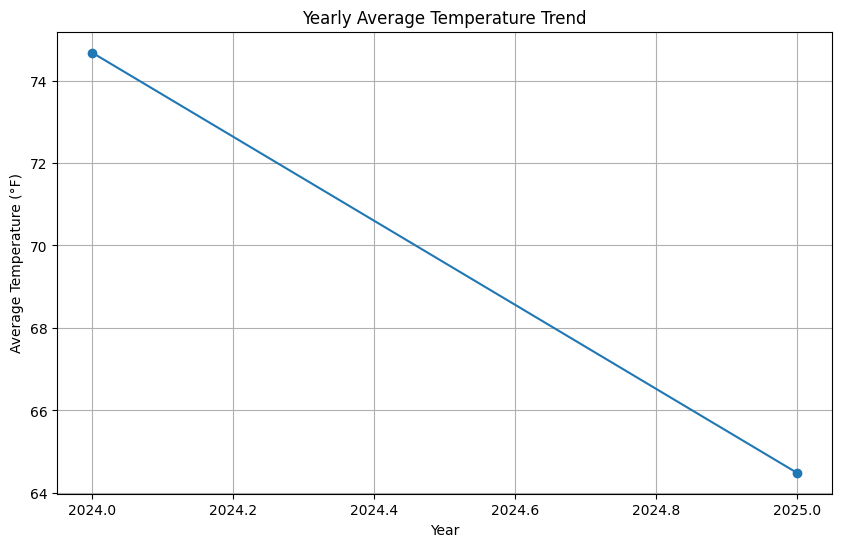

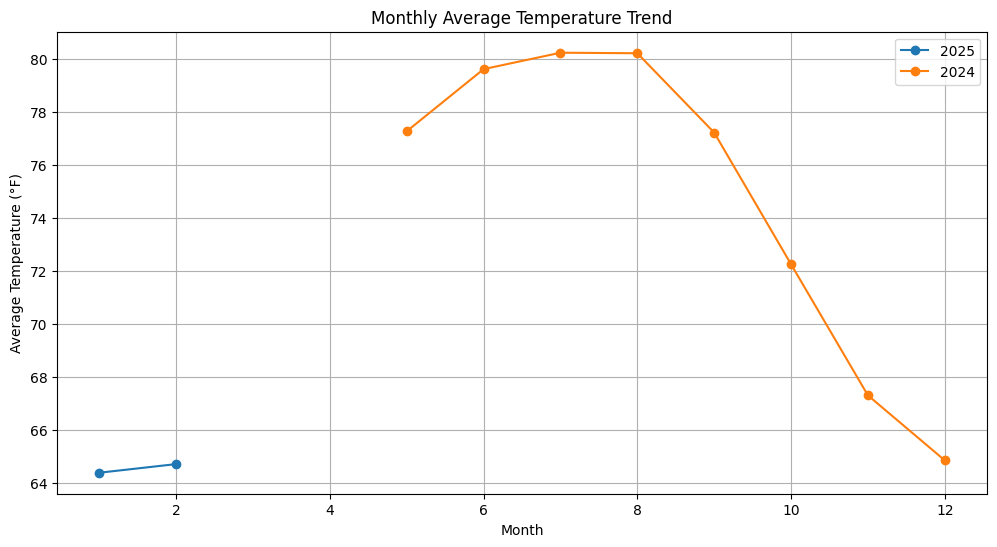

In [141]:
from pyspark.sql.functions import col, avg, to_date, month, year


# Group data by year and calculate average temperature
df_yearly_avg = df_cleaned.groupBy(year(col('date')).alias('year')).agg(avg(col('temperature_fahrenheit')).alias('avg_temp'))
 
# Show yearly average temperature
df_yearly_avg.show()
 
# Group data by month and calculate average temperature
df_monthly_avg = df_cleaned.groupBy(year(col('date')).alias('year'), month(col('date')).alias('month')).agg(avg(col('temperature_fahrenheit')).alias('avg_temp')).orderBy('month')
 
# Show monthly average temperature
df_monthly_avg.show()
 
# Convert DataFrame to Pandas for visualization
df_yearly_avg_pandas = df_yearly_avg.toPandas()
df_monthly_avg_pandas = df_monthly_avg.toPandas()
 
import matplotlib.pyplot as plt
 
# Plot yearly average temperature
plt.figure(figsize=(10, 6))
plt.plot(df_yearly_avg_pandas['year'], df_yearly_avg_pandas['avg_temp'], marker='o')
plt.title('Yearly Average Temperature Trend')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°F)')
plt.grid(True)
plt.show()
 
# Plot monthly average temperature
plt.figure(figsize=(12, 6))
for year in df_monthly_avg_pandas['year'].unique():
    yearly_data = df_monthly_avg_pandas[df_monthly_avg_pandas['year'] == year]
    plt.plot(yearly_data['month'], yearly_data['avg_temp'], marker='o', label=str(year))
plt.title('Monthly Average Temperature Trend')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°F)')
plt.grid(True)
plt.legend()
plt.show()

+----+--------------------+
|year|          avg_precip|
+----+--------------------+
|2024|0.003560907544510...|
|2025|0.003035616388672...|
+----+--------------------+

+----+-----+--------------------+
|year|month|          avg_precip|
+----+-----+--------------------+
|2025|    1|0.003058608009470946|
|2025|    2|0.002991343328550711|
|2024|    5| 0.00412067913339039|
|2024|    6|0.003543998567194...|
|2024|    7|0.003936570448458...|
|2024|    8|0.003892473061472...|
|2024|    9| 0.00380635240224643|
|2024|   10|0.003270764067843309|
|2024|   11|0.003359119773028908|
|2024|   12|0.002838709632765172|
+----+-----+--------------------+



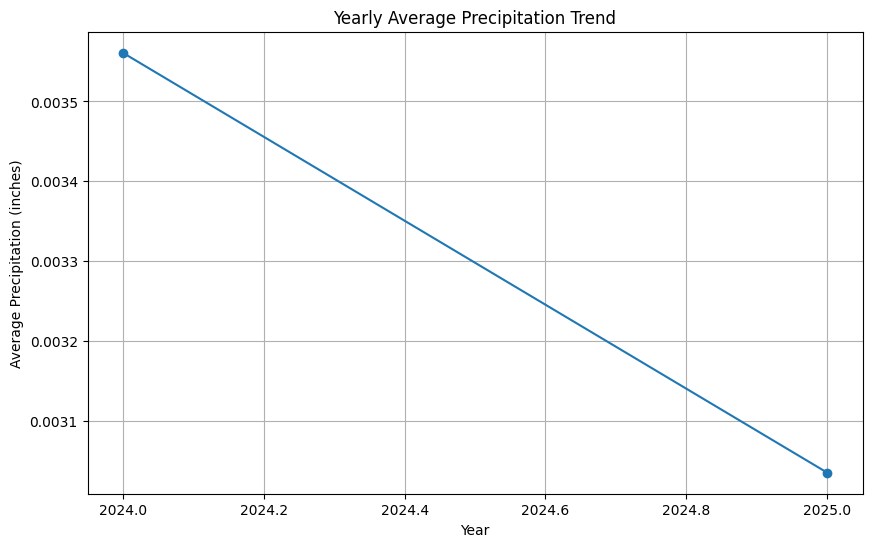

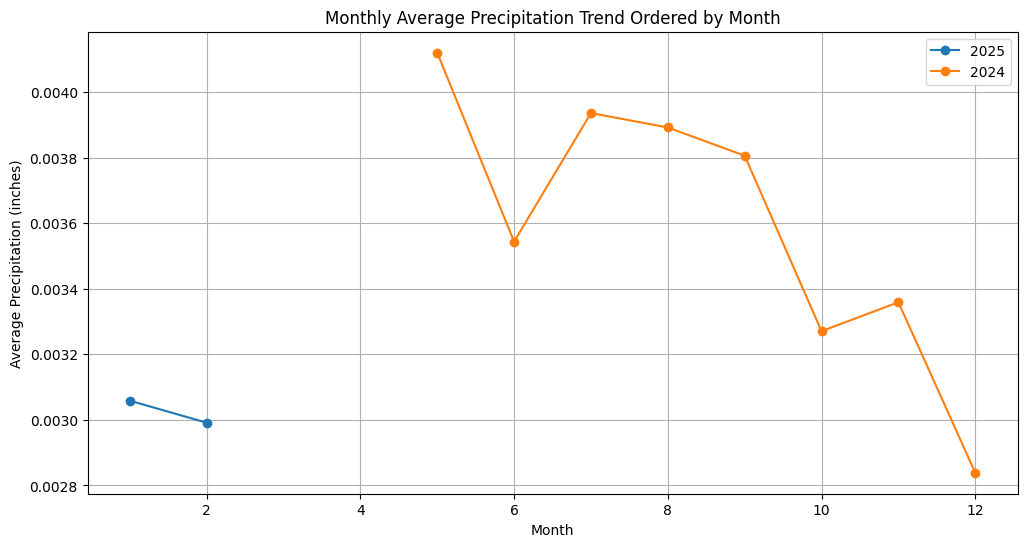

In [142]:
from pyspark.sql.functions import col, avg, to_date, month, year

# Group data by year and calculate average precipitation
df_yearly_avg = df_cleaned.groupBy(year(col('date')).alias('year')).agg(avg(col('precip_in')).alias('avg_precip'))
 
# Show yearly average precipitation
df_yearly_avg.show()
 
# Group data by year and month, calculate average precipitation, and order by month
df_monthly_avg = df_cleaned.groupBy(year(col('date')).alias('year'), month(col('date')).alias('month')).agg(avg(col('precip_in')).alias('avg_precip')).orderBy('month')
 
# Show monthly average precipitation ordered by month
df_monthly_avg.show()
 
# Convert DataFrame to Pandas for visualization
df_yearly_avg_pandas = df_yearly_avg.toPandas()
df_monthly_avg_pandas = df_monthly_avg.toPandas()
 
import matplotlib.pyplot as plt
 
# Plot yearly average precipitation
plt.figure(figsize=(10, 6))
plt.plot(df_yearly_avg_pandas['year'], df_yearly_avg_pandas['avg_precip'], marker='o')
plt.title('Yearly Average Precipitation Trend')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (inches)')
plt.grid(True)
plt.show()
 
# Plot monthly average precipitation ordered by month
plt.figure(figsize=(12, 6))
for year in df_monthly_avg_pandas['year'].unique():
    yearly_data = df_monthly_avg_pandas[df_monthly_avg_pandas['year'] == year]
    plt.plot(yearly_data['month'], yearly_data['avg_precip'], marker='o', label=str(year))
plt.title('Monthly Average Precipitation Trend Ordered by Month')
plt.xlabel('Month')
plt.ylabel('Average Precipitation (inches)')
plt.grid(True)
plt.legend()
plt.show()

DataFrame[country: string, location_name: string, latitude: double, longitude: double, timezone: string, last_updated_epoch: int, last_updated: timestamp, temperature_celsius: double, temperature_fahrenheit: double, condition_text: string, wind_mph: double, wind_kph: double, wind_degree: int, wind_direction: string, pressure_mb: double, pressure_in: double, precip_mm: double, precip_in: double, humidity: int, cloud: int, feels_like_celsius: double, feels_like_fahrenheit: double, visibility_km: double, visibility_miles: double, uv_index: double, gust_mph: double, gust_kph: double, air_quality_Carbon_Monoxide: double, air_quality_Ozone: double, air_quality_Nitrogen_dioxide: double, air_quality_Sulphur_dioxide: double, air_quality_PM2.5: double, air_quality_PM10: double, air_quality_us-epa-index: int, air_quality_gb-defra-index: int, sunrise: string, sunset: string, moonrise: string, moonset: string, moon_phase: string, moon_illumination: int, date_only: date, date: date, year: int, month

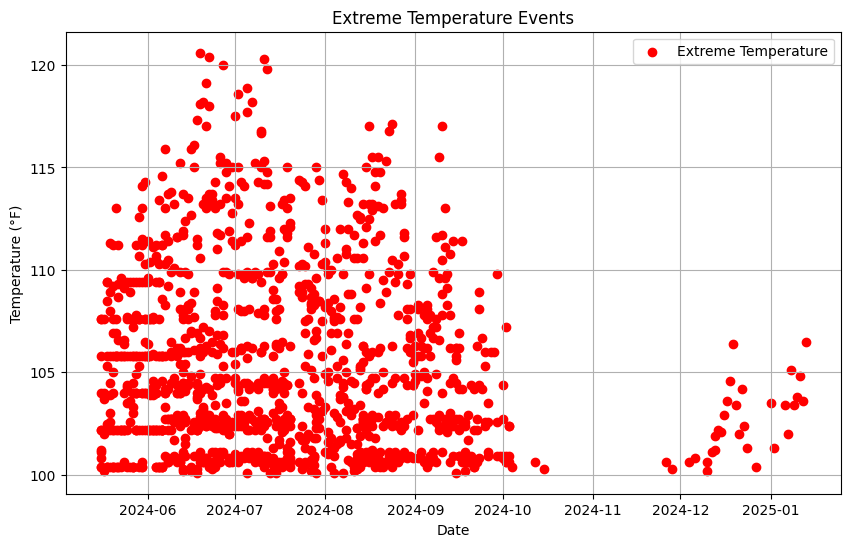

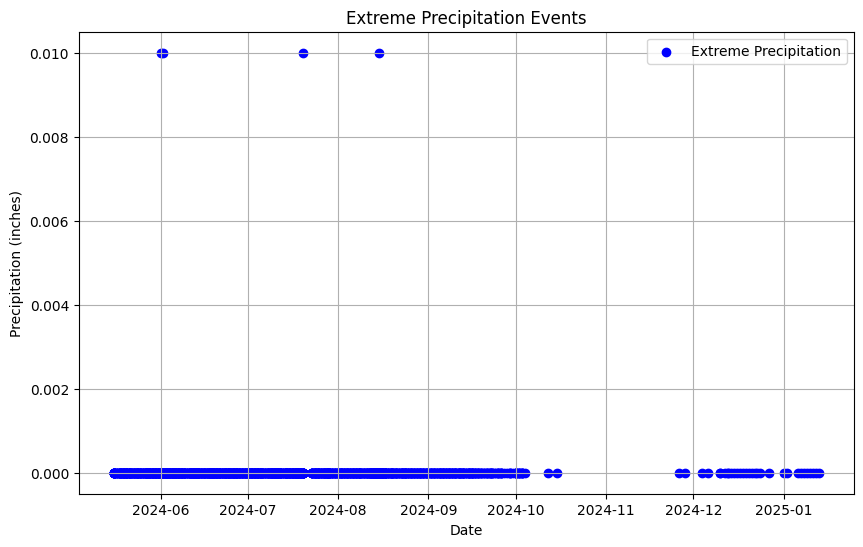

In [143]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, abs, mean, stddev, to_date, when
 
 
 
# Ensure the 'date' column is in date format
df_cleaned = df_cleaned.withColumn('date', to_date(col('date'), 'yyyy-MM-dd'))
 
#thresholds for extreme weather events

temp_threshold = 100.0  #Fahrenheit
precip_threshold = 5.0  #inches
 
# Identify extreme temperature events
extreme_temp_events = df_cleaned.filter(col('temperature_fahrenheit') > temp_threshold)
 
# Identify extreme precipitation events
extreme_precip_events = df_cleaned.filter(col('precip_in') > precip_threshold)
 
extreme_events = extreme_temp_events.union(extreme_precip_events)
 
# Add event type column
extreme_events = extreme_events.withColumn(
    'event_type',
    when(col('temperature_fahrenheit') > temp_threshold, 'Extreme Temperature')
    .when(col('precip_in') > precip_threshold, 'Extreme Precipitation')
)
 
# Show extreme events
display(extreme_events)
 
# Convert DataFrame to Pandas for visualization
extreme_events_pandas = extreme_events.toPandas()
 
import matplotlib.pyplot as plt
 
# Plot extreme temperature events
plt.figure(figsize=(10, 6))
plt.scatter(extreme_events_pandas['date'], extreme_events_pandas['temperature_fahrenheit'], color='red', label='Extreme Temperature')
plt.title('Extreme Temperature Events')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.grid(True)
plt.legend()
plt.show()
 
# Plot extreme precipitation events
plt.figure(figsize=(10, 6))
plt.scatter(extreme_events_pandas['date'], extreme_events_pandas['precip_in'], color='blue', label='Extreme Precipitation')
plt.title('Extreme Precipitation Events')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.grid(True)
plt.legend()
plt.show()

In [144]:
import psycopg2
import pandas as pd

# Define connection parameters
conn_params = {
    "host": "localhost",
    "database": "postgres",
    "user": "postgres",
    "password": "new_password"
}

# Create connection and cursor
conn = psycopg2.connect(**conn_params)
cur = conn.cursor()

# Query the locations table
cur.execute("SELECT id, location_name FROM locations")

# Fetch all rows
location_mapping = {location_name: id for id, location_name in cur.fetchall()}

# Close the cursor and connection
cur.close()
conn.close()


In [145]:
import pyspark
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import psycopg2

# Ensure location_mapping is defined and populated
if 'location_mapping' not in globals() or not location_mapping:
    # Define connection parameters
    conn_params = {
        "host": "localhost",
        "database": "postgres",
        "user": "postgres",
        "password": "new_password"
    }

    # Create connection and cursor
    conn = psycopg2.connect(**conn_params)
    cur = conn.cursor()

    # Query the locations table
    cur.execute("SELECT id, location_name FROM locations")

    # Fetch all rows
    location_mapping = {location_name: id for id, location_name in cur.fetchall()}

    # Close the cursor and connection
    cur.close()
    conn.close()

# Define a UDF to get location_id
def get_location_id(location_name):
    return location_mapping.get(location_name)

# Register the UDF
get_location_id_udf = udf(get_location_id, IntegerType())

# Convert df2 to a Spark DataFrame if not already
if not isinstance(df2, pyspark.sql.dataframe.DataFrame):
    df2 = spark.createDataFrame(df2)

# Add the location_id column to the DataFrame
df3 = df2.withColumn("location_id", get_location_id_udf(df2.location_name))




In [146]:
# # Assuming df3 is your PySpark DataFrame
# df1.write.csv(r"C:\Users\aravi\Desktop\Assignment\weather_data_with_ids.csv", header=True, mode="overwrite")

# print("CSV file created successfully using Spark!")

In [147]:
# import pandas as pd
# import os

# # Path to the folder containing part files
# folder_path = 'cleaned_weather_data.csv'
# # Create a list to store individual DataFrames
# dataframes = []

# # Loop through the part files and read each into a pandas DataFrame
# for file_name in os.listdir(folder_path):
#     if file_name.startswith("part-") and file_name.endswith(".csv"):
#         file_path = os.path.join(folder_path, file_name)
#         df = pd.read_csv(file_path)  # Read each part file
#         dataframes.append(df)

# # Combine all DataFrames into a single DataFrame
# combined_df = pd.concat(dataframes, ignore_index=True)

# # Save the combined DataFrame to a single CSV file
# output_file = r'C:\Users\aravi\Desktop\Assignment\final_cleaned_data.csv'
# combined_df.to_csv(output_file, index=False)

# print(f"Combined CSV saved to: {output_file}")



In [148]:
# import psycopg2  

# # Database connection details  
# db_params = {
#     "dbname": "postgres",
#     "user": "postgres",
#     "password": "new_password",
#     "host": "localhost",
#     "port": "5432"
# }

# # Function to load data using COPY
# def load_data(table_name, file_path):
#     try:
#         conn = psycopg2.connect(**db_params)
#         cursor = conn.cursor()
        
#         sql = f"COPY {table_name} FROM STDIN WITH CSV HEADER DELIMITER ','"
        
#         with open(file_path, 'r') as file:
#             cursor.copy_expert(sql, file)
        
#         conn.commit()
#         print(f"Successfully loaded data into {table_name}")

#     except Exception as e:
#         print(f"Error: {e}")
    
#     finally:
#         cursor.close()
#         conn.close()

# load_data("locations", r"final_cleaned_data.csv") 

In [149]:
# import pandas as pd

# # 1. Load the main CSV file
# main_df = pd.read_csv('final_cleaned_data.csv')  # Replace with your file name

# # 2. Create DataFrames for each table
# # Locations Table
# locations_df = main_df[['country', 'location_name', 'latitude', 'longitude', 'timezone']].drop_duplicates()

# # Weather Observations Table
# weather_observations_df = main_df[[
#     'id', 'location_id', 'last_updated', 'last_updated_epoch', 'date_only',
#     'temperature_celsius', 'temperature_fahrenheit', 'wind_mph', 'wind_kph',
#     'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in',
#     'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
#     'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
#     'uv_index', 'gust_mph', 'gust_kph'
# ]].drop_duplicates()

# # Weather Conditions Table
# weather_conditions_df = main_df[[
#     'id', 'weather_observation_id', 'condition_text', 'sunrise', 'sunset',
#     'moonrise', 'moonset', 'moon_phase', 'moon_illumination'
# ]].drop_duplicates()

# # Air Quality Table
# air_quality_df = main_df[[
#     'id', 'weather_observation_id', 'air_quality_carbon_monoxide',
#     'air_quality_ozone', 'air_quality_nitrogen_dioxide',
#     'air_quality_sulphur_dioxide', 'air_quality_pm25', 'air_quality_pm10',
#     'air_quality_us_epa_index', 'air_quality_gb_defra_index'
# ]].drop_duplicates()

# # Daily Weather Table
# daily_weather_df = main_df[[
#     'id', 'location_id', 'date_only', 'avg_temperature_celsius',
#     'avg_precipitation_mm', 'avg_humidity', 'avg_wind_speed_kph'
# ]].drop_duplicates()

# # Monthly Weather Table
# monthly_weather_df = main_df[[
#     'id', 'location_id', 'year', 'month', 'avg_temperature_celsius',
#     'avg_precipitation_mm', 'avg_humidity', 'avg_wind_speed_kph'
# ]].drop_duplicates()

# # Extreme Weather Events Table
# extreme_weather_events_df = main_df[[
#     'id', 'location_id', 'date_only', 'event_type', 'event_description'
# ]].drop_duplicates()

# # 3. Save each DataFrame to a separate CSV file
# locations_df.to_csv('locations.csv', index=False)
# weather_observations_df.to_csv('weather_observations.csv', index=False)
# weather_conditions_df.to_csv('weather_conditions.csv', index=False)
# air_quality_df.to_csv('air_quality.csv', index=False)
# daily_weather_df.to_csv('daily_weather.csv', index=False)
# monthly_weather_df.to_csv('monthly_weather.csv', index=False)
# extreme_weather_events_df.to_csv('extreme_weather_events.csv', index=False)

# print("CSV files created successfully!")

In [150]:
# # Inserting Datas Into Database Tables
# # Import libraries
# from pyspark.sql import SparkSession
# import pandas as pd
# from sqlalchemy import create_engine
# import psycopg2

In [151]:
# df=spark.read.csv("final_cleaned_data.csv",header=True, inferSchema=True, multiLine=True, escape='"')


In [152]:

#     "dbname": "postgres",
#     "user": "postgres",
#     "password": "new_password",
#     "host": "localhost",
#     "port": "5432"
# }

# db_name = "postgres"
# db_host = "postgres"
# db_username = "retail_db_user"
# db_password = "retail_db_password"
# db_port = "5432"

In [153]:
# # Import libraries
# from pyspark.sql import SparkSession
# import pandas as pd
# from sqlalchemy import create_engine
# from pyspark.sql.functions import when

In [154]:
# # Initialize Spark session
# spark = SparkSession.builder.appName("InsertDataIntoPostgreSQL").getOrCreate()

In [155]:
# # Read the CSV file into a PySpark DataFrame
# df = spark.read.csv("final_cleaned_data.csv", header=True, inferSchema=True, multiLine=True, escape='"')

In [156]:
# db_name = "postgres"  # Set database name to postgres
# db_host = "localhost"  # Replace with the actual host
# db_username = "db_user"  # User created earlier
# db_password = "db_password"  # Password for the user
# db_port = "5432"  # Default PostgreSQ

In [157]:
# engine = create_engine(f'postgresql+psycopg2://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}')

In [158]:
# # Convert PySpark DataFrame to Pandas DataFrame
# df_pd = df.toPandas()

In [159]:
# # Specify the table name
# table_name = "weather_data"

# # Insert data into PostgreSQL table
# try:
#     # Write the Pandas DataFrame to the PostgreSQL table
#     df_pd.to_sql(table_name, con=engine, if_exists='append', index=False)
#     print(f"Data inserted into {table_name} successfully")
# except Exception as e:
#     print(f"An error occurred: {e}")
# finally:
#     # Close the connection
#     engine.dispose()

In [160]:
# import pandas as pd

# # Load CSV and check column names
# df_pd = pd.read_csv("final_cleaned_data.csv")
# print(df_pd.columns)


In [161]:
# import pandas as pd
# from sqlalchemy import create_engine

# # Define the corrected table column names (as per your PostgreSQL table schema)
# table_columns = [
#     "country", "location_name", "latitude", "longitude", "timezone",
#     "last_updated_epoch", "last_updated", "temperature_celsius",
#     "temperature_fahrenheit", "condition_text", "wind_mph", "wind_kph",
#     "wind_degree", "wind_direction", "pressure_mb", "pressure_in",
#     "precip_mm", "precip_in", "humidity", "cloud", "feels_like_celsius",
#     "feels_like_fahrenheit", "visibility_km", "visibility_miles", "uv_index",
#     "gust_mph", "gust_kph", "air_quality_carbon_monoxide", "air_quality_ozone",
#     "air_quality_nitrogen_dioxide", "air_quality_sulphur_dioxide",
#     "air_quality_pm25", "air_quality_pm10", "air_quality_us_epa_index",
#     "air_quality_gb_defra_index", "sunrise", "sunset", "moonrise",
#     "moonset", "moon_phase", "moon_illumination", "date_only", "date",
#     "year", "month", "day"
# ]

# # Load the CSV file
# df_pd = pd.read_csv("final_cleaned_data.csv", header=None)  # Load without considering headers

# # Rename the columns
# df_pd.columns = table_columns

# # Ensure any column requiring specific formatting, like datetime, is handled
# df_pd["last_updated"] = pd.to_datetime(df_pd["last_updated"])

# # Verify the renamed DataFrame
# print(df_pd.head())

# # PostgreSQL database connection details
# db_name = "postgres"
# db_host = "localhost"
# db_username = "db_user"
# db_password = "db_password"
# db_port = "5432"

# # Create SQLAlchemy engine
# engine = create_engine(f'postgresql+psycopg2://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}')

# # Insert data into PostgreSQL table
# table_name = "weather_data"  # The name of the PostgreSQL table

# try:
#     # Insert the DataFrame into the PostgreSQL table
#     df_pd.to_sql(table_name, con=engine, if_exists="append", index=False)
#     print("Data inserted successfully!")
# except Exception as e:
#     print(f"An error occurred: {e}")
# finally:
#     engine.dispose()


In [162]:
# import pandas as pd

# # Specify the expected data types for each column
# dtype_mapping = {
#     0: 'string',  # country
#     1: 'string',  # location_name
#     2: 'float',   # latitude
#     3: 'float',   # longitude
#     4: 'string',  # timezone
#     5: 'int64',   # last_updated_epoch
#     7: 'float',   # temperature_celsius
#     8: 'float',   # temperature_fahrenheit
#     # Add more mappings as necessary...
# }

# # Load CSV with specified dtypes
# df_pd = pd.read_csv("final_cleaned_data.csv", header=None, dtype=dtype_mapping, low_memory=False)


In [163]:
# import pandas as pd

# # Load the CSV without headers
# df = pd.read_csv("final_cleaned_data.csv", header=None, low_memory=False)

# # Define the correct column names as per the PostgreSQL table schema
# column_names = [
#     "country", "location_name", "latitude", "longitude", "timezone",
#     "last_updated_epoch", "last_updated", "temperature_celsius",
#     "temperature_fahrenheit", "condition_text", "wind_mph", "wind_kph",
#     "wind_degree", "wind_direction", "pressure_mb", "pressure_in",
#     "precip_mm", "precip_in", "humidity", "cloud", "feels_like_celsius",
#     "feels_like_fahrenheit", "visibility_km", "visibility_miles", "uv_index",
#     "gust_mph", "gust_kph", "air_quality_carbon_monoxide", "air_quality_ozone",
#     "air_quality_nitrogen_dioxide", "air_quality_sulphur_dioxide",
#     "air_quality_pm25", "air_quality_pm10", "air_quality_us_epa_index",
#     "air_quality_gb_defra_index", "sunrise", "sunset", "moonrise",
#     "moonset", "moon_phase", "moon_illumination", "date_only", "date",
#     "year", "month", "day"
# ]

# # Assign the column names to the DataFrame
# df.columns = column_names


In [164]:
# # Replace invalid time values in the 'moonset' column
# valid_time_format = "%I:%M %p"  # Expected format (e.g., '01:11 AM')

# def fix_time(value):
#     try:
#         return pd.to_datetime(value, format=valid_time_format).time()
#     except (ValueError, TypeError):
#         return None  # Replace invalid values with None (NULL in SQL)

# df["moonset"] = df["moonset"].apply(fix_time)
# df["moonrise"] = df["moonrise"].apply(fix_time)
# df["sunrise"] = df["sunrise"].apply(fix_time)
# df["sunset"] = df["sunset"].apply(fix_time)


In [165]:
# # Revalidate all columns to ensure they comply with the schema
# numeric_columns = [
#     "latitude", "longitude", "temperature_celsius", "temperature_fahrenheit",
#     "wind_mph", "wind_kph", "wind_degree", "pressure_mb", "pressure_in",
#     "precip_mm", "precip_in", "humidity", "cloud", "feels_like_celsius",
#     "feels_like_fahrenheit", "visibility_km", "visibility_miles", "uv_index",
#     "gust_mph", "gust_kph", "air_quality_carbon_monoxide", "air_quality_ozone",
#     "air_quality_nitrogen_dioxide", "air_quality_sulphur_dioxide",
#     "air_quality_pm25", "air_quality_pm10", "air_quality_us_epa_index",
#     "air_quality_gb_defra_index", "moon_illumination", "year", "month", "day"
# ]

# df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")

# # Remove rows with critical NULL values (optional)
# df = df.dropna(subset=["last_updated", "latitude", "longitude"])


In [166]:
# from sqlalchemy import create_engine

# # Database connection details
# db_name = "postgres"
# db_host = "localhost"
# db_username = "db_user"
# db_password = "db_password"
# db_port = "5432"

# # Create a SQLAlchemy engine
# engine = create_engine(f'postgresql+psycopg2://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}')

# # Insert data into PostgreSQL
# try:
#     df.to_sql("weather_data1", con=engine, if_exists="append", index=False)
#     print("Data inserted successfully!")
# except Exception as e:
#     print(f"An error occurred: {e}")
# finally:
#     engine.dispose()
